# Perturbation Analysis

Can INFFT enforce constraints while still staying close to target function? 
In other words, if our target function slightly violates the constraints, does the result from the INFFT still come close to approximating it?

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from torch.nn.functional import conv1d, pad
from torch.fft import fft
from torchaudio.transforms import FFTConvolve
import time

In [3]:
from qsppack import nlfa

from matplotlib import pyplot as plt
import numpy as np
from numpy.polynomial import chebyshev as cheb
from scipy.signal import fftconvolve

In [12]:
from numpy.polynomial import Chebyshev
from scipy import fftpack

In [4]:
def inverse_nonlinear_FFT(a: np.ndarray, b: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Computes the inverse nonlinear FFT of a and b.

    Parameters
    ----------
    a : np.ndarray
        Input array a of length n.
    b : np.ndarray
        Input array b of length n.

    Returns
    -------
    tuple of np.ndarray
        A tuple containing gammas, xi_n, and eta_n.
    
    Examples
    --------
    >>> inverse_nonlinear_FFT(np.array([0.1, -0.5, -0.6]), np.array([0.2, -0.5, 0.3]))[0]
    array([2., 1., 3.])
    """
    n = len(a)

    # Step 1: base case
    if n == 1:
        gammas = np.array([b[0]/a[0]])
        eta_1 = np.array([1 / np.sqrt(1 + np.abs(gammas[0])**2)])
        xi_1 = gammas * eta_1
        return gammas, xi_1, eta_1
    
    # Step 2: first recursive call
    m = int(np.ceil(n/2))
    gammas = np.zeros(n, dtype=np.complex128)
    gammas[:m], xi_m, eta_m = inverse_nonlinear_FFT(a[:m], b[:m])

    # Step 3: compute coefficients of am and bm
    eta_m_sharp = np.append(0, eta_m[::-1])
    xi_m_sharp = np.append(0, xi_m[::-1])
    am = (fftconvolve(eta_m_sharp, a) + fftconvolve(xi_m_sharp, b))[m:]
    bm = (fftconvolve(eta_m, b) - fftconvolve(xi_m, a))[m:]

    # Step 4: second recursive call
    gammas[m:], xi_mn, eta_mn = inverse_nonlinear_FFT(am[:n-m], bm[:n-m])

    # Step 5: final calculation and output
    xi_n = fftconvolve(eta_m_sharp, xi_mn) + np.append(fftconvolve(xi_m, eta_mn), 0)
    eta_n = np.append(fftconvolve(eta_m, eta_mn), 0) - fftconvolve(xi_m_sharp, xi_mn)
    return gammas, xi_n, eta_n


def forward_nonlinear_FFT(gammas: np.ndarray, m=0, debug=False) -> tuple[np.ndarray, np.ndarray]:
    """
    Computes the forward nonlinear FFT, producing the polynomials a^* and b
    from the rotation parameters gammas.

    Parameters
    ----------
    gammas : np.ndarray
        Array of complex rotation parameters gamma_k of length n.
    m : int, optional
        starting index of gammas to use in the recursion.

    Returns
    -------
    tuple of np.ndarray
        A tuple (a_star, b) of length n+1 and n respectively, where a_star
        is the conjugate polynomial coefficients of a^*(z), and b is b(z).
    """
    n = len(gammas)

    # base case
    if n <= 2:
        prefactor = 1 / np.sqrt(1 + np.abs(gammas[0])**2)
        if n == 2:
            prefactor /= np.sqrt(1 + np.abs(gammas[1])**2)
        if debug:
            prefactor = 1
        b = prefactor * np.append(np.zeros(m, dtype=np.complex128), gammas)
        a_star = prefactor * np.array([1, -np.conj(gammas[0])*gammas[1]]) if n == 2 else np.array([prefactor])
        return a_star, b
    
    # recursive step
    m_new = int(np.ceil(n/2))
    if debug:
        print("m={}, n={}".format(m, n))
    a_star_left, b_left = forward_nonlinear_FFT(gammas[:m_new], debug=debug)
    a_star_right, b_right = forward_nonlinear_FFT(gammas[m_new:], m_new, debug=debug)
    
    # compute the convolution of the left and right parts
    if debug:
        print("a_star_left: ", a_star_left)
        print("b_left: ", b_left)
        print("a_star_right: ", a_star_right)
        print("b_right: ", b_right)
        print("b1: ", fftconvolve(np.conj(a_star_left[::-1]), b_right))
        print("b2: ", fftconvolve(a_star_right, b_left))
    b1 = fftconvolve(np.conj(a_star_left[::-1]), b_right)
    b1 = b1[len(a_star_left)-1:]
    b2 = fftconvolve(a_star_right, b_left)
    b2 = np.append(b2, np.zeros(len(b1)-len(b2), dtype=np.complex128))
    a_star1 = -fftconvolve(np.conj(b_left[::-1]), b_right)
    a_star1 = a_star1[len(b_left)-1:]
    a_star2 = fftconvolve(a_star_left, a_star_right)
    a_star2 = np.append(a_star2, np.zeros(len(a_star1)-len(a_star2), dtype=np.complex128))
    b = b1 + b2
    a_star = a_star1 + a_star2

    return a_star, np.append(np.zeros(m, dtype=np.complex128), b)

## Get coeffs for Cheb approx of target function that violates constraints slightly

--- Approximating f(x) = scale / x with Odd Parity ---
Sum of absolute values of even coefficients: 0.00e+00
Maximum approximation error on [0.10, 1.00]: 6.19e-02



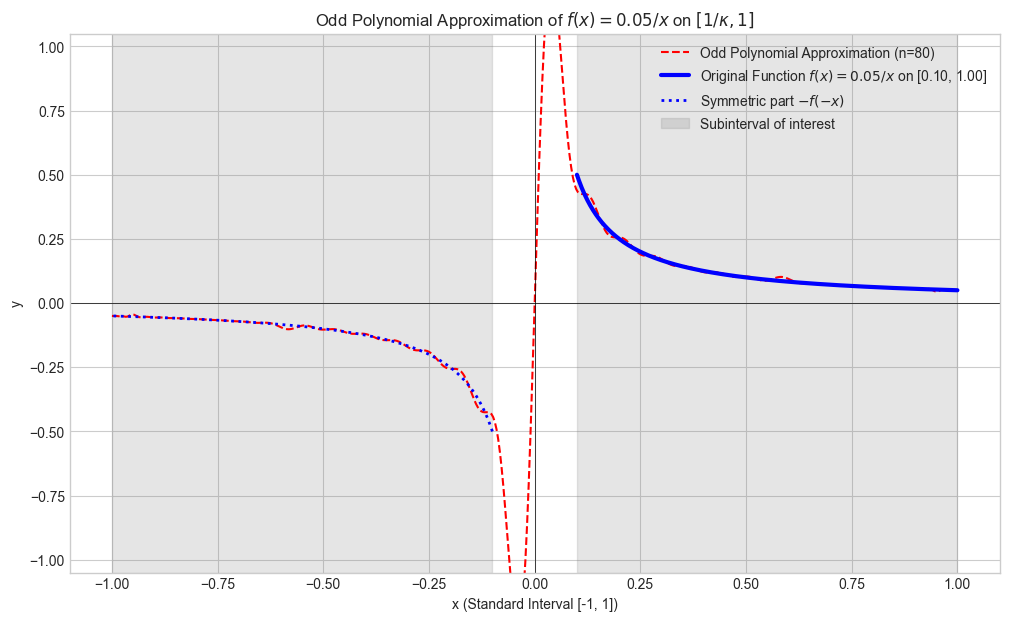

In [22]:
def _get_cheb_coeffs_from_values(values):
    """Helper to compute Chebyshev coefficients from values via DCT."""
    n = len(values) - 1
    if n <= 0:
        return values.copy()
    
    # Use the Fast Chebyshev Transform (via DCT) to get the coefficients.
    coeffs = fftpack.dct(values, type=1) / n
    
    # The first and last coefficients have a different scaling.
    coeffs[0] /= 2
    coeffs[n] /= 2
    return coeffs

def cheb_interp_subinterval(f, a, b, n, parity='odd'):
    """
    Computes standard Chebyshev coefficients for a function f of definite
    parity, defined on a subinterval [a, b] within [-1, 1].

    Args:
        f (callable): The function to be interpolated on [a, b].
        a (float): The lower bound of the subinterval. Must be >= -1.
        b (float): The upper bound of the subinterval. Must be <= 1.
        n (int): The degree of the final Chebyshev polynomial.
        parity (str, optional): Can be 'even' or 'odd'. Defaults to 'odd'.

    Returns:
        numpy.ndarray: An array of n+1 Chebyshev coefficients for the standard
                       [-1, 1] basis, with the specified parity enforced.
    """
    if not (-1 <= a < b <= 1):
        raise ValueError("The interval [a, b] must be a subinterval of [-1, 1].")
    if parity not in ['even', 'odd']:
        raise ValueError("parity must be 'even' or 'odd'.")

    # --- Construct a symmetric problem to enforce parity ---
    # 1. Define a symmetric interval [-c, c] that contains [a, b]
    c = max(abs(a), abs(b))
    sym_domain = [-c, c]

    # 2. Get Chebyshev nodes on this symmetric interval
    sym_nodes = c * np.cos(np.pi * np.arange(n + 1) / n)
    
    # 3. Populate function values, using parity to fill in missing points
    sym_values = np.zeros(n + 1)
    for i, x in enumerate(sym_nodes):
        if a <= x <= b:
            sym_values[i] = f(x)
        elif a <= -x <= b:
            if parity == 'even':
                sym_values[i] = f(-x)
            else: # odd
                sym_values[i] = -f(-x)
        else:
            # This case occurs if the function is only defined on [a,b]
            # and we need a point outside of [a,b] U [-b,-a].
            # We assume f is a global function with known parity.
            sym_values[i] = f(x)

    # 4. Get coeffs for the symmetric polynomial on domain [-c, c]
    coeffs_sym = _get_cheb_coeffs_from_values(sym_values)

    # Enforce parity strictly due to potential floating point inaccuracies
    if parity == 'even':
        coeffs_sym[1::2] = 0.0
    else: # odd
        coeffs_sym[0::2] = 0.0
    
    p_sym = Chebyshev(coeffs_sym, domain=sym_domain)

    # 5. Convert to the standard [-1, 1] domain
    p_main = p_sym.convert(kind=Chebyshev, domain=[-1, 1])
    return p_main.coef



# --- Specific Example: Approximating scale/x with an odd polynomial ---
print("--- Approximating f(x) = scale / x with Odd Parity ---")

kappa = 10.0
n_degree = 80
scale = 1.0 / 20.0

# Define the function and the subinterval [1/kappa, 1]
f = lambda x: scale * (1.0 / x)
a = 1.0 / kappa
b = 1.0

# Get the coefficients, enforcing odd parity
coeffs = cheb_interp_subinterval(f, a, b, n_degree, parity='odd')

# Verify that the even coefficients are zero
print(f"Sum of absolute values of even coefficients: {np.sum(np.abs(coeffs[0::2])):.2e}")

# Calculate the maximum error on the interval of interest
x_sub_plot = np.linspace(a, b, 400)
y_true_sub = f(x_sub_plot)
y_approx_sub = cheb.chebval(x_sub_plot, coeffs)
max_error = np.max(np.abs(y_true_sub - y_approx_sub))
print(f"Maximum approximation error on [{a:.2f}, {b:.2f}]: {max_error:.2e}\n")

# --- Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the approximation over the full [-1, 1] interval to see its odd symmetry
x_full_plot = np.linspace(-1, 1, 500)
y_approx_plot = cheb.chebval(x_full_plot, coeffs)

ax.plot(x_full_plot, y_approx_plot, 'r--', label=f'Odd Polynomial Approximation (n={n_degree})')

# Plot the true function scale/x on the subinterval
ax.plot(x_sub_plot, y_true_sub, 'b-', label=f'Original Function $f(x)={scale:.2f}/x$ on [{a:.2f}, {b:.2f}]', linewidth=3)

# Also plot the symmetric part of the true function for context
ax.plot(-x_sub_plot, -y_true_sub, 'b:', label=f'Symmetric part $-f(-x)$', linewidth=2)

ax.axvspan(a, b, color='gray', alpha=0.2, label=f'Subinterval of interest')
ax.axvspan(-b, -a, color='gray', alpha=0.2)

ax.set_title(f'Odd Polynomial Approximation of $f(x)={scale:.2f}/x$ on $[1/\\kappa, 1]$')
ax.set_xlabel('x (Standard Interval [-1, 1])')
ax.set_ylabel('y')
ax.legend()
# Adjust y-limits to reflect the new scale
ax.set_ylim(-scale * kappa * 1.1 - 0.5, scale * kappa * 1.1 + 0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
plt.show()


## Apply INFFT and then NFFT

In [28]:
bcoeffs = nlfa.b_from_cheb(coeffs[1::2], 1)

def objective_torch(x, P):
    """
    Computes the loss for the optimization problem.

    This function calculates the loss as the squared norm of the difference
    between the target tensor P and the convolution of x with its flipped version.

    Parameters
    ----------
    x : torch.Tensor
        The input tensor for which the loss is computed.
    P : torch.Tensor
        The target tensor to compare against.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    x.requires_grad = True

    # Compute loss using squared distance function
    loss = torch.norm(P - FFTConvolve("full").forward(x, torch.flip(x, dims=[0])))**2
    return 1000*loss


def closure():
    """
    Closure function for the optimizer.

    This function zeroes the gradients, computes the loss using the objective_torch
    function, and performs backpropagation to compute the gradients.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    optimizer.zero_grad()
    loss = objective_torch(initial, conv_p_negative)
    loss.backward()
    return loss


# Set the size of the polynomial
N = len(bcoeffs)

# Generate a random polynomial of size N on the specified device
poly = torch.tensor(bcoeffs, dtype=torch.float32, device=device)

# Define the granularity for padding
granularity = 2 ** 25

# Pad the polynomial to match the granularity
P = pad(poly, (0, granularity - poly.shape[0]))

# Compute the FFT of the padded polynomial
ft = fft(P)

# Normalize the polynomial using the maximum norm of its FFT
P_norms = ft.abs()
poly /= torch.max(P_norms)

# Compute the negative convolution of the polynomial with its flipped version
conv_p_negative = FFTConvolve("full").forward(poly, torch.flip(poly, dims=[0])) * -1

# Adjust the last element to ensure the norm condition
conv_p_negative[poly.shape[0] - 1] = 1 - torch.norm(poly) ** 2

# Set up optimizer
initial = torch.randn(poly.shape[0], device=device, requires_grad=True)
initial = (initial / torch.norm(initial)).clone().detach().requires_grad_(True)
optimizer = torch.optim.LBFGS([initial], max_iter=1000, line_search_fn="strong_wolfe", tolerance_grad=1e-10)

# Perform the optimization step using the closure function and record the time
t0 = time.time()
optimizer.step(closure)
t1 = time.time()
total = t1 - t0

print(f'N: {N}')
print(f'Time: {total}')
print(f'Final: {closure().item()}')
print(f"# Iterations: {optimizer.state[optimizer._params[0]]['n_iter']}")
print("-----------------------------------------------------")

N: 62
Time: 2.3263370990753174
Final: 0.00020424681133590639
# Iterations: 513
-----------------------------------------------------


In [29]:
acoeffs = initial.detach().numpy()
# print(f"acoeffs: {acoeffs}")
print(f"bcoeffs: {bcoeffs[:5]}")

bcoeffs: [-0.0137054   0.00085     0.01290461 -0.01467177  0.0026028 ]


In [23]:
bcoeffs = nlfa.b_from_cheb(coeffs[1::2], 1)
acoeffs = nlfa.weiss(bcoeffs, 2**9)
acoeffs = acoeffs.astype(np.float64)
bcoeffs = bcoeffs.astype(np.float64)

gammas, _, _ = inverse_nonlinear_FFT(acoeffs, bcoeffs)
# print(f"gammas: {gammas}")
new_a, new_b = forward_nonlinear_FFT(gammas)
# print(f"new_a: {new_a}")
print(f"new_b: {new_b[:5]}")

new_b: [-0.00057794+4.39716905e-19j  0.00133331-9.18748987e-18j
 -0.00303337+1.56333667e-18j  0.00469176+9.86262715e-18j
 -0.00535031+1.17014139e-18j]


/var/folders/bz/68lg1ys109jbpl3rbpx1jjmw0000gn/T/ipykernel_26742/3641394697.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  acoeffs = acoeffs.astype(np.float64)


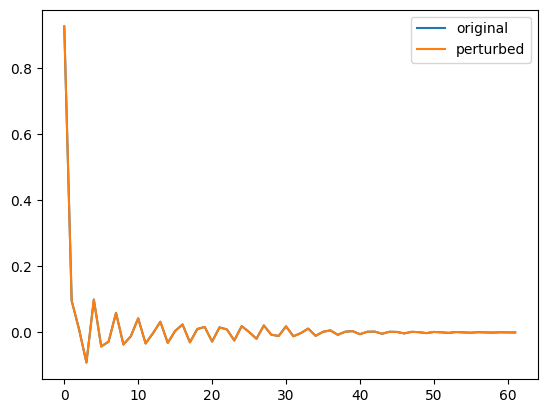

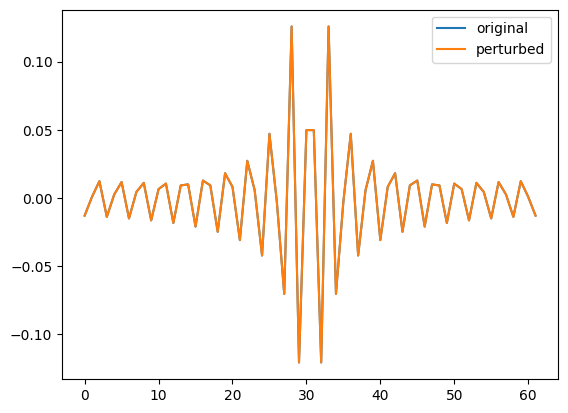

In [11]:
plt.plot(acoeffs, label="original")
plt.plot(new_a, label="perturbed")
plt.legend(loc="best")
plt.show()
plt.plot(bcoeffs, label="original")
plt.plot(new_b, label="perturbed")
plt.legend(loc="best")
plt.show()

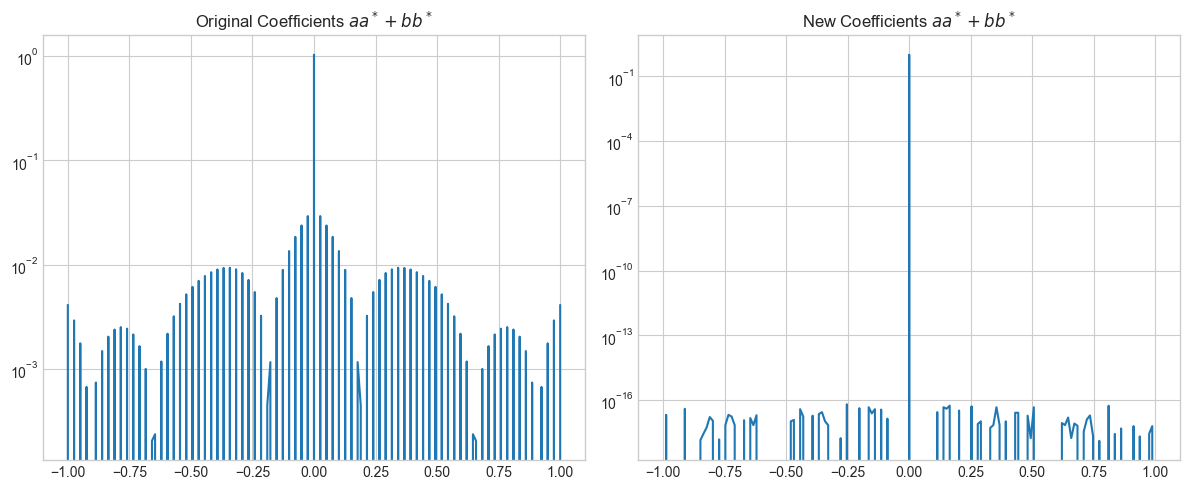

In [30]:
coefs_constraint = fftconvolve(acoeffs, np.flip(np.conj(acoeffs)), mode='full') + fftconvolve(bcoeffs, np.flip(np.conj(bcoeffs)), mode='full')
coefs_constraint_new = fftconvolve(new_a, np.flip(np.conj(new_a)), mode='full') + fftconvolve(new_b, np.flip(np.conj(new_b)), mode='full')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
xvals = np.linspace(-1, 1, len(coefs_constraint))

axs[0].plot(xvals, np.real(coefs_constraint))
axs[0].set_yscale("log")
axs[0].set_title(r"Original Coefficients $aa^* + bb^*$")

axs[1].plot(xvals, np.real(coefs_constraint_new))
axs[1].set_yscale("log")
axs[1].set_title(r"New Coefficients $aa^* + bb^*$")

plt.tight_layout()
plt.savefig("perturbation_lin_sys_verification.png")

/var/folders/bz/68lg1ys109jbpl3rbpx1jjmw0000gn/T/ipykernel_26742/1548683097.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  new_coeffs[1::2] = new_b[int(len(new_b)/2-1)::-1] + new_b[int(len(new_b)/2)::]


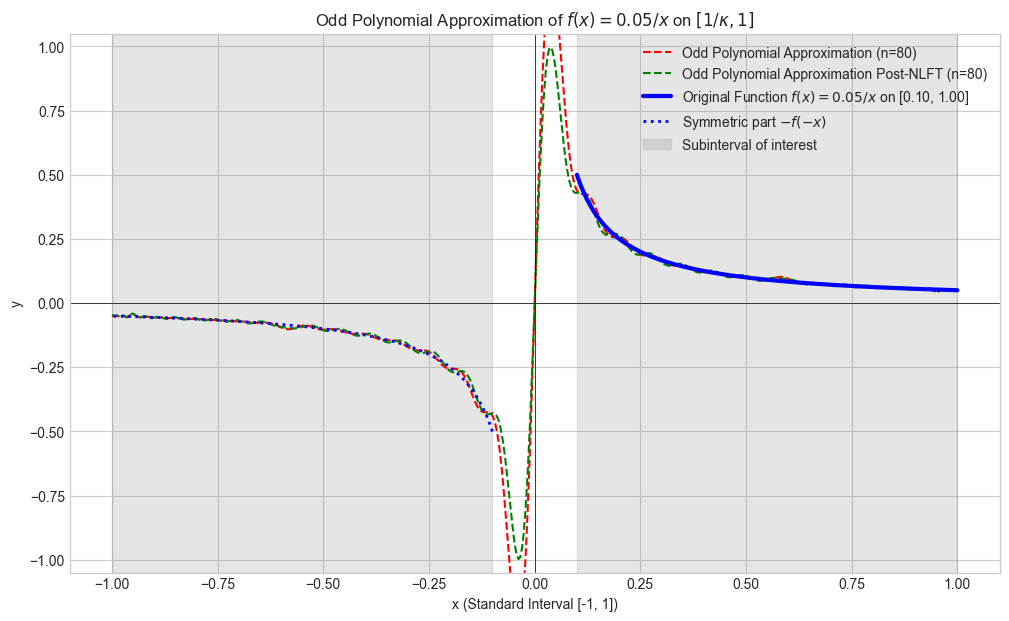

In [26]:
# --- Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the approximation over the full [-1, 1] interval to see its odd symmetry
x_full_plot = np.linspace(-1, 1, 500)
y_approx_plot = cheb.chebval(x_full_plot, coeffs)

ax.plot(x_full_plot, y_approx_plot, 'r--', label=f'Odd Polynomial Approximation (n={n_degree})')


# Plot the post-NLFT approximation constrained
new_coeffs = np.zeros(len(coeffs))
new_coeffs[1::2] = new_b[int(len(new_b)/2-1)::-1] + new_b[int(len(new_b)/2)::]
ax.plot(x_full_plot, cheb.chebval(x_full_plot, new_coeffs), 'g--', label=f'Odd Polynomial Approximation Post-NLFT (n={n_degree})')


# Plot the true function scale/x on the subinterval
ax.plot(x_sub_plot, y_true_sub, 'b-', label=f'Original Function $f(x)={scale:.2f}/x$ on [{a:.2f}, {b:.2f}]', linewidth=3)

# Also plot the symmetric part of the true function for context
ax.plot(-x_sub_plot, -y_true_sub, 'b:', label=f'Symmetric part $-f(-x)$', linewidth=2)

ax.axvspan(a, b, color='gray', alpha=0.2, label=f'Subinterval of interest')
ax.axvspan(-b, -a, color='gray', alpha=0.2)

ax.set_title(f'Odd Polynomial Approximation of $f(x)={scale:.2f}/x$ on $[1/\\kappa, 1]$')
ax.set_xlabel('x (Standard Interval [-1, 1])')
ax.set_ylabel('y')
ax.legend()
# Adjust y-limits to reflect the new scale
ax.set_ylim(-scale * kappa * 1.1 - 0.5, scale * kappa * 1.1 + 0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
plt.savefig("perturbation_lin_sys.png")

## Check new function

In [17]:
np.linalg.norm(bcoeffs - new_b)

0.6905513282533303

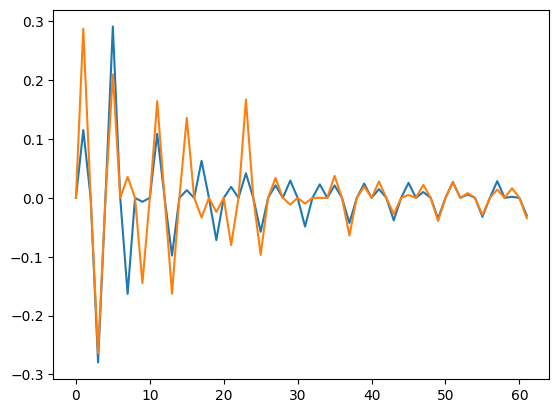

In [40]:
old_coeffs = np.zeros(len(coeffs))
old_coeffs[1::2] = 2*bcoeffs[int(len(bcoeffs)/2-1)::-1]

plt.plot(old_coeffs)
plt.plot(new_coeffs)
plt.show()

In [39]:
max(cheb.chebval(x, new_coeffs))

0.9987183016105723

/var/folders/bz/68lg1ys109jbpl3rbpx1jjmw0000gn/T/ipykernel_16000/2039203806.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  new_coeffs[1::2] = new_b[int(len(new_b)/2-1)::-1] + new_b[int(len(new_b)/2)::]


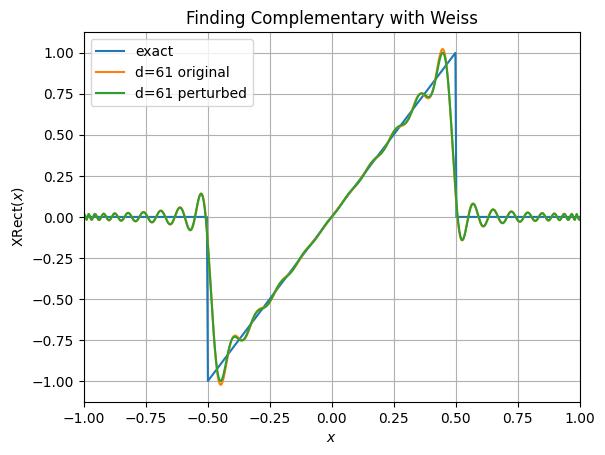

In [38]:
new_coeffs = np.zeros(len(coeffs))
new_coeffs[1::2] = new_b[int(len(new_b)/2-1)::-1] + new_b[int(len(new_b)/2)::]

plt.grid()
plt.plot(x, y, label="exact")
plt.plot(x, cheb.chebval(x, coeffs), label=f"d={degree} original")
plt.plot(x, cheb.chebval(x, new_coeffs), label=f"d={degree} perturbed")
plt.xlim(-1, 1)
plt.xlabel(r"$x$")
plt.ylabel(r"XRect$(x)$")
plt.legend()
plt.title("Finding Complementary with Weiss")
plt.savefig("weiss_stability.png")

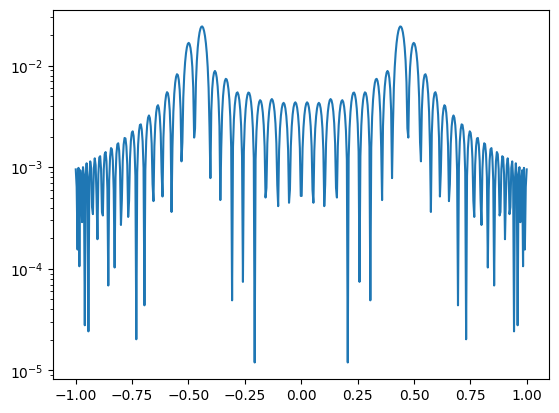

In [46]:
plt.plot(x, np.abs(cheb.chebval(x, coeffs) - cheb.chebval(x, new_coeffs)))
plt.yscale("log")
plt.show()

/var/folders/bz/68lg1ys109jbpl3rbpx1jjmw0000gn/T/ipykernel_16000/3071846245.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  new_coeffs[1::2] = new_b[int(len(new_b)/2-1)::-1] + new_b[int(len(new_b)/2)::]


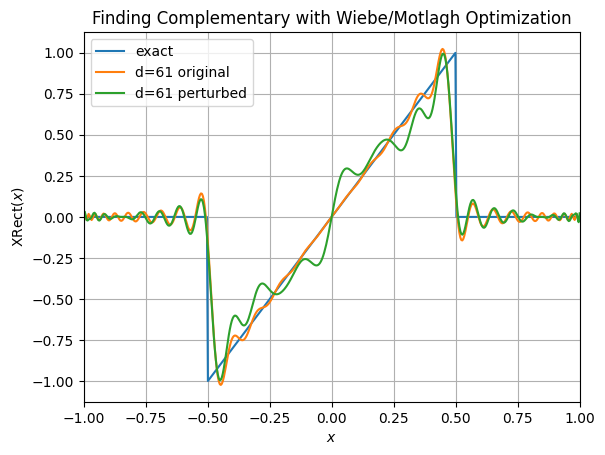

In [34]:
new_coeffs = np.zeros(len(coeffs))
new_coeffs[1::2] = new_b[int(len(new_b)/2-1)::-1] + new_b[int(len(new_b)/2)::]

plt.grid()
plt.plot(x, y, label="exact")
plt.plot(x, cheb.chebval(x, coeffs), label=f"d={degree} original")
plt.plot(x, cheb.chebval(x, -new_coeffs), label=f"d={degree} perturbed")
plt.xlim(-1, 1)
plt.xlabel(r"$x$")
plt.ylabel(r"XRect$(x)$")
plt.legend()
plt.title("Finding Complementary with Wiebe/Motlagh Optimization")
plt.savefig("wiebe_motlagh_stability.png")

In [94]:
max(cheb.chebval(x, coeffs))

0.9707935452990378

In [18]:
yvals = cheb.chebval(x, new_coeffs)
print(f"min: {min(yvals)}")
print(f"max: {max(yvals)}")

min: -1.019738171724042
max: 1.0197381717240421


In [51]:
np.linalg.norm(old_coeffs - new_coeffs)

0.8314241643173416

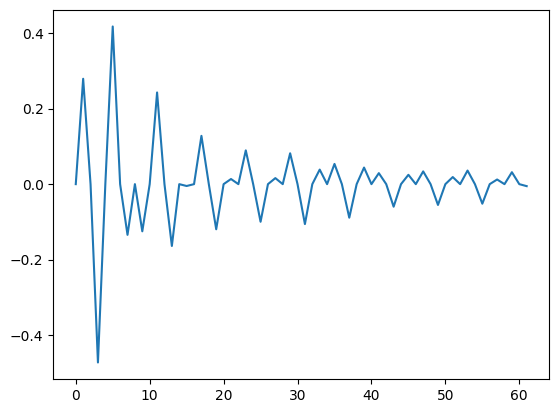

In [52]:
plt.plot(old_coeffs - new_coeffs)